Using a ACO to learn health gathering and mywayhome (not done)

Import everything

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import math
from torch.utils.tensorboard import SummaryWriter
from vizdoom import * #Import all of vizdoom
import time #To make the program sleep (wait), so we can actually see what's happening
from gymnasium import Env #Import OpenAI Gym's Env class
from gymnasium.spaces import Discrete, Box #Import OpenAI Gym's Discrete and Box spaces
import cv2 #OpenCV for image processing, used for modifying the DOOM environment to make it run faster 
from stable_baselines3.common.callbacks import BaseCallback #Import the BaseCallback class from stable_baselines3 to learn from the environment
from stable_baselines3.common import env_checker #Import the env_checker class from stable_baselines3 to check the environment
import os #To create directories for saving models
import sys #To change the path so we can import the pathfinder module
import matplotlib.pyplot as plt

original_sys_path = sys.path.copy() #Come back to this path later after we navigate to the parent directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  #Add the parent directory to the path so we can import the pathfinder module
from pathfinder import doomfinder, create_new_best_generation_directory, gamefinder #Import functions from the pathfinder module
sys.path = original_sys_path #Set the path back to the original path

Define enviornment (for mywayhome)

In [11]:
#Note we are using are representing the map as a 960x832 grid

#Map extreme verticies
MIN_X, MAX_X = 160, 1120
MIN_Y, MAX_Y = -704, 128

#Grid dimensions, the map size is actually 960x832 but this allows us some leeway if we get close to the edge
GRID_WIDTH = 960 #1 unit per cell
GRID_HEIGHT = 832 #1 units per cell

class mywayhome_VZG(Env): #Used for mywayhome config
    def __init__(self, config_path, render=False, grid_size=(GRID_HEIGHT, GRID_WIDTH), pheromone_evaporation_rate=0.001, pheromone_map = None, frameskip = 1): #Constructor
        #Args:
            #config_path (str): The path to the configuration file
            #render (bool): Whether to render the environment or not, false by default
            #grid_size (tuple): The size of the grid (x, y) for the environment
            #pheromone_evaporation_rate (float): The rate at which pheromones evaporate over time
            #pheromone_map (np.array): Optional pre-filled pheromone map, if not provided, it will be initialized with low pheromone levels
            #frameskip (int): The number of frames to skip between actions

        super(mywayhome_VZG, self).__init__() #Inherit from Env class

        #Setup game environment
        self.game = vizdoom.DoomGame() #Create a DoomGame object
        self.game.set_doom_game_path(gamefinder('DOOM2.WAD')) #Set the path to the game
        self.game.load_config(config_path) #Load the configuration file from file path
        self.game.set_window_visible(render) #Set window visibility based on render argument
        self.game.init() #Initialize the game
        self.frameskip = frameskip #Set the frameskip
        
        #Setup action and observation space
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8) #Observation space, 100x160x1 image
        self.action_space = Discrete(6) #Action space, 6 actions (turn left, turn right, move forward, move left, move right, move backwards)

        #Grid dimensions and pheromone setup
        self.grid_size = grid_size #Set the grid size as specified 
        if pheromone_map is not None:
            self.pheromone_map = pheromone_map #Use the provided pheromone map if available
        else: #If no pheromone map is provided, initialize a new one
            self.pheromone_map = np.ones(grid_size) * 0  #Start with adjustable pheromone levels across the grid (adjustable by the multiplier)
        self.pheromone_evaporation_rate = pheromone_evaporation_rate  #Controls how fast pheromones decay over time

        #Get game variables
        game_variables = self.game.get_state().game_variables
        xpos, ypos, angle = game_variables #Unpack the game variables
        
        self.xpos = xpos #X position of the player
        self.ypos = ypos #Y position of the player
        self.angle = angle #Angle of the player 

    def coord_to_grid(self, x, y): #Convert coordinates to grid indices
        #Args:
            #x (int): X coordinate to convert
            #y (int): Y coordinate to convert
        #Returns:
            #grid_x, grid_y (tuple): The grid indices corresponding to the coordinates
        #Raises:
            #ValueError: If the coordinates are out of bounds

        #Ensure coordinates are within world bounds
        if x < MIN_X or x > MAX_X or y < MIN_Y or y > MAX_Y:
            raise ValueError(f"Coordinates ({x}, {y}) are out of bounds!")
        
        #Normalize coordinates to range [0, 1]
        norm_x = (x - MIN_X) / (MAX_X - MIN_X)
        norm_y = (y - MIN_Y) / (MAX_Y - MIN_Y)
        
        #print(f"norm_x = {norm_x}, norm_y = {norm_y}") #Debug print

        #Scale to grid dimensions and floor the values to ensure integers
        grid_x = int(norm_x * (GRID_WIDTH - 1))
        grid_y = int(norm_y * (GRID_HEIGHT - 1))

        #print(f"grid_x = {grid_x}, grid_y = {grid_y}") #Debug print

        return (grid_x, grid_y)

    def step(self, action, limit = 1000): #Take a step in the environment 
        #Args:
            #action (int): The action to take
            #limit (int): Unimplemented "limit" for the episode, most likely will be a time limit
        #Returns:
            #observation (np.array): The screen buffer of the environment
            #reward (float): The reward for the action taken
            #terminated (bool) Whether the episode is finished or not (by reaching the goal)
            #truncated (bool): Whether the episode has reached some terminal state without reaching the goal (ie: running out of time)
            #info (dict): Additional information about the environment

        #print(f"xpos = {self.xpos}, ypos = {self.ypos}, angle = {self.angle}") #Debug print

        #Specify actions and take a step
        actions = np.identity(6) #Create an identity matrix with 6 rows (6 actions), TURN_LEFT, TURN_RIGHT, MOVE_FOWARD, MOVE_LEFT, MOVE_RIGHT, MOVE_BACKWARD, these are the actions we can take in the environment
        self.game.make_action(actions[action], self.frameskip) #Take an action in the action space, second parameter is frame skip (how many frames we take an action for)
        truncated = False #Not implemented yet, so set to False. The idea is that if step passes some sort of limit, like a time limit, then the episode is truncated.
        info = {"xpos": self.xpos, "ypos": self.ypos, "angle": self.angle} # Initialize info with current position and angle
        reward = 0 #Initialize reward to 0

        if self.game.get_state(): #If the game is not finished
            observation = self.game.get_state().screen_buffer #Get the screen buffer
            observation = self.greyscale(observation) #Convert the image to greyscale
            
            (prev_grid_x, prev_grid_y) = self.coord_to_grid(self.xpos, self.ypos) #Find the grid indices of the previous position
            xpos, ypos, angle = self.game.get_state().game_variables #Get the game variables
            self.xpos = xpos #Update the x position
            self.ypos = ypos #Update the y position
            self.angle = angle #Update the angle

            info = {"xpos": self.xpos, "ypos": self.ypos, "angle": self.angle} #Add position and angle to the info dictionary
            (grid_x, grid_y) = self.coord_to_grid(xpos, ypos) #Find the grid indices of the current position

        #Update pheromones based on movement feedback
            movement_actions = [2, 3, 4, 5] #The actions that move the agent
            if (grid_x, grid_y) == (prev_grid_x, prev_grid_y) and (action in movement_actions): #No movement detected
                self.pheromone_map[grid_y, grid_x] = 0 #Mark as a wall
            else: #If this isnt a wall, add pheromones
                self.pheromone_map[grid_y, grid_x] += 0.1 #Deposit pheromones
                self.pheromone_map *= (1 - self.pheromone_evaporation_rate) #Simulate evaporation
        else: #If the game is finished
            observation = np.zeros(self.observation_space.shape) #Return a blank screen

        terminated = self.game.is_episode_finished() #Check if the episode is finished

        return observation, reward, terminated, truncated, info

    def reset(self): #Reset the environment when we start a new game
        #Args:
            #seed (int): The seed for the random number generator
        #Returns:
            #(observation, info) (tuple)
                #observation (np.array): The screen buffer of the environment
                #info (dict): Additional information about the environment
                
        self.game.new_episode() #Start a new episode
        game_variables = self.game.get_state().game_variables  #Get the game variables   
        self.xpos, self.ypos, self.angle = game_variables  #Unpack the game variables, set agent to its random starting position 

        state = self.game.get_state().screen_buffer
        observation = self.greyscale(state)  #Convert the initial screen state to greyscale
        info = {"xpos": self.xpos, "ypos": self.ypos, "angle": self.angle} #Add position and angle to the info dictionary

        return observation, info  #Return the observation and any additional info

    def greyscale(self, observation): #Convert the environment image to greyscale and resize it
        #Args:
            #observation (np.array): The image of the environment (the current game frame)
        #Returns:
            #grey_return (np.array): The resized greyscale image of the environment
        
        grey = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY) #Convert the image to greyscale
        resize = cv2.resize(grey, (160, 100), interpolation=cv2.INTER_CUBIC) #Resize the image to 160x100 (frame size)
        state = np.reshape(resize, (100, 160, 1)) #Reshape to 100x160x1 for compatibility with neural networks
        
        return state

    def render(self, render_in_greyscale=False): #Render the environment for a frame
        #Args:
            #render_in_greyscale (bool): Whether to render the environment in greyscale or not
        
        if self.game.get_state() and render_in_greyscale:  #Only render if there's a valid game state
            observation = self.game.get_state().screen_buffer
            greyscale_obs = self.greyscale(observation)  #Convert the observation to greyscale
            cv2.imshow("VizDoom Environment", greyscale_obs.squeeze())  #Remove extra dimension and display
            cv2.waitKey(1)  #Wait 1ms between frames to allow for rendering
        elif self.game.get_state():  #Only render if there's a valid game state
            observation = self.game.get_state().screen_buffer
            cv2.imshow("VizDoom Environment", observation.squeeze())  #Render the environment without greyscale
            cv2.waitKey(1)  #Wait 1ms between frames to allow for rendering
        else:
            print("No game state to render.")

    def get_state(self): #Get the current state of the environment
        #Returns:
            #state (np.array): The current state of the environment
        return self.game.get_state()

    def get_agent_position(self): #Get the current position of the agent (tuple of x, y coordinates)
        #Returns:
            #(xpos, ypos) (tuple): The current position of the agent

        return (self.xpos, self.ypos)

    def close(self): #Close the environment when done
        self.game.close()  #Terminate the game

Define Plotting, Saving, and Finding Pheromone Maps

In [23]:
def plot_pheromone_grid(pheromone_grid, title, log_dir, iteration, save_image):
    plt.imshow(pheromone_grid, cmap='hot', interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    if save_image:
        image_path = os.path.join(log_dir, f"pheromone_grid_iteration_{iteration}.png")
        plt.savefig(image_path)
        #print(f"Pheromone grid image saved to {image_path}")
    plt.show()

def create_run_directory(base_dir="aco_runs/vizdoom_aco_mywayhome"): #Create a new run directory for the ACO algorithm
    os.makedirs(base_dir, exist_ok=True)
    existing_runs = [int(d.split('_')[-1]) for d in os.listdir(base_dir) if d.split('_')[-1].isdigit()]
    run_number = max(existing_runs, default=0) + 1
    run_dir = os.path.join(base_dir, f"run_{run_number}")
    os.makedirs(run_dir, exist_ok=True)
    #Create saved maps directory within the run directory
    maps_dir = os.path.join(run_dir, "saved_maps")
    os.makedirs(maps_dir, exist_ok=True)
    #Create log directory within the run directory
    log_dir = os.path.join(run_dir, "log")
    os.makedirs(log_dir, exist_ok=True)
    return run_dir, log_dir, maps_dir

def save_pheromone_grid(pheromone_grid, maps_dir, iteration):
    filename = os.path.join(maps_dir, f"pheromone_grid_iteration_{iteration}.npy")
    np.save(filename, pheromone_grid)
    #print(f"Pheromone grid saved to {filename}")

def load_pheromone_grid(run_dir="aco_runs/vizdoom_aco_mywayhome", run_number=0, filename="pheromone_grid_iteration_x.npy"):
    run_dir = os.path.join(run_dir, f"run_{run_number}/saved_maps")
    filepath = os.path.join(run_dir, filename)
    #print(filepath) #Print the path
    if os.path.exists(filepath):
        pheromone_grid = np.load(filepath)
        #print(f"Pheromone grid loaded from {filepath}")
        return pheromone_grid
    else:
        #print(f"No saved pheromone grid found at {filepath}")
        return None

Define Training

In [13]:
def aco_training(env, num_ants=10, iterations=50, alpha=1, beta=0.5, pheromone_deposit=1.0, run_dir="aco_runs/vizdoom_aco_mywayhome", log_dir = "aco_runs/vizdoom_aco_mywayhome/run_x/log", maps_dir = "aco_runs/vizdoom_aco_mywayhome/run_x/saved_maps"): #Train the ACO algorithm in the ViZDoom environment
    """
    Train a bot to pathfind in the ViZDoom environment using ACO.
    
    Args:
        env (Env): The ViZDoom environment.
        num_ants (int): Number of ants (pathfinding agents) per iteration.
        iterations (int): Total iterations for ACO.
        alpha (float): Importance of pheromones.
        beta (float): Importance of heuristic (distance to goal).
        pheromone_deposit (float): Amount of pheromone deposited on successful paths.
        run_dir (str): Directory to save the ACO run data.
        log_dir (str): Directory to save logs and images.
        maps_dir (str): Directory to save pheromone maps.
    """
    #Initialize pheromone grid
    pheromone_grid = env.pheromone_map
    
    frameskip = env.frameskip #Get the frameskip from the environment

    #Generate list of goal positions
    GOAL_POSITIONS = [env.coord_to_grid(x, y) for x in range(1008, 1072) for y in range(-324, -315)] #Goal can be accessed from any of these positions
    
    #Heuristic function: inverse distance to the closest goal
    def heuristic(x, y):
        min_distance = float('inf')
        for (gx, gy) in GOAL_POSITIONS:
            distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
            if distance < min_distance:
                min_distance = distance
        return 1.0 / (min_distance + 1e-6)

    #Simulate movement locally without stepping the game, this is unfinished I have to account for angle
    def simulate_move(x, y, angle, move):
        #print(f"x passed is {x}, y passed is {y}, angle passed is {angle}")  #Debug print

        step_size = 1  #Approximate movement step size; tune based on game behavior
        angle_rad = np.deg2rad(angle)  #Convert angle to radians

        if move == 0:  #TURN_LEFT (no position change)
            return x, y, angle - 90
        elif move == 1:  #TURN_RIGHT (no position change)
            return x, y, angle + 90
        elif move == 2:  #MOVE_FORWARD
            return x + step_size * np.cos(angle_rad), y + step_size * np.sin(angle_rad), angle
        elif move == 3:  #MOVE_LEFT
            return x - step_size * np.sin(angle_rad), y + step_size * np.cos(angle_rad), angle
        elif move == 4:  #MOVE_RIGHT
            return x + step_size * np.sin(angle_rad), y - step_size * np.cos(angle_rad), angle
        elif move == 5:  #MOVE_BACKWARD
            return x - step_size * np.cos(angle_rad), y - step_size * np.sin(angle_rad), angle
        return x, y, angle

    #Function to select next move based on pheromones and heuristic
    def select_next_move(x, y, angle):
        possible_moves = [0, 1, 2, 3, 4, 5]  #TURN_LEFT, TURN_RIGHT, etc.
        probs = []

        for move in possible_moves:
            #Simulate movement locally without stepping the game
            simulated_x, simulated_y, simulated_angle = simulate_move(x, y, angle, move)
            #print(f"Simulated move: {move}, x: {simulated_x}, y: {simulated_y}, angle: {simulated_angle}")  #Debug print

            #Convert to grid indices and calculate pheromone + heuristic
            grid_x, grid_y = env.coord_to_grid(simulated_x, simulated_y)
            if 0 <= grid_x < GRID_WIDTH and 0 <= grid_y < GRID_HEIGHT:
                pheromone = pheromone_grid[grid_y, grid_x]
                eta = heuristic(grid_x, grid_y)
                probs.append((pheromone ** alpha) * (eta ** beta))
            else:
                probs.append(0.0)  #Invalid moves have zero probability

        #Normalize probabilities
        probs = np.array(probs)
        if probs.sum() == 0:
            probs = np.ones(len(possible_moves)) / len(possible_moves)  #Default equal prob
        else:
            probs /= probs.sum()

        return np.random.choice(possible_moves, p=probs)

    #Main ACO loop
    
    for iteration in range(iterations):
        print(f"Iteration {iteration + 1}/{iterations}")
        
        for ant in range(num_ants):
            
            terminated = False
            tics = 10 #Start at 10 tics

            observation, info = env.reset()
            x, y, angle = env.xpos, env.ypos, env.angle
            path = []
            success = False

            while not terminated:  #Steps are limited to number of tics (2100) by the config
                action = select_next_move(x, y, angle)
                observation, _, terminated, _, info = env.step(action)
                x, y, angle = info['xpos'], info['ypos'], info['angle']
                path.append((env.coord_to_grid(x, y)))

                tics = tics + 1 * frameskip #Increment tics, multiply by frameskip to account for the frameskip
            
            if tics < 2100: #If the ant reached the goal
                print(f"Ant {ant} reached the goal in {tics} steps.")
                success = True

            #Update pheromones
            for (px, py) in path: #Give a little boost to path if the ant reached the goal
                pheromone_grid[py, px] += pheromone_deposit if success else 0.0
            
            #print(f"Ant {iteration}.{ant}, tics: {tics}, success: {success}")
            #print(f"Path: {path}")
            #plot_pheromone_grid(pheromone_grid, (f"Pheromone Grid After Ant {iteration}.{ant}"), log_dir, iteration, save_image=False) #Plot the pheromone grid after each ant
        
        if(iteration % 5 == 0 and iteration < iterations): #Save the pheromone grid after every 5 iterations
            plot_pheromone_grid(pheromone_grid, (f"Iteration {iteration}"), log_dir, iteration, save_image=True)  #Save the image after every 10 iterations
        else: 
            plot_pheromone_grid(pheromone_grid, (f"Iteration {iteration}"), log_dir, iteration, save_image=False)  #Plot the pheromone grid after each iteration
        save_pheromone_grid(pheromone_grid, maps_dir, iteration)  #Save the pheromone grid at the end of iteration

    plot_pheromone_grid(pheromone_grid, (f"Final Map (Iteration {iterations})"), log_dir, iteration, save_image=True)  #Plot/save the final pheromone grid
    env.close()

Enviornment to Test Maps Trained

In [31]:
def test_saved_maps(env, num_tests=5, alpha = 1, beta = 0.5, pheromone_grid=None):
    """
    Test the saved pheromone maps in the ViZDoom environment.
    
    Args:
        env (Env): The ViZDoom environment.
        num_tests (int): Number of test runs to perform.
        alpha (float): Importance of pheromones.
        beta (float): Importance of heuristic (distance to goal).
        pheromone_grid (np.array): The saved pheromone grid to test.
    """
    #Load the saved pheromone grid
    if pheromone_grid is None:
        print("No saved pheromone grid found.")
        return
    
    env.pheromone_map = pheromone_grid
    
    #Generate list of goal positions
    GOAL_POSITIONS = [env.coord_to_grid(x, y) for x in range(1008, 1072) for y in range(-324, -315)]
    
    #Heuristic function: inverse distance to the closest goal
    def heuristic(x, y):
        min_distance = float('inf')
        for (gx, gy) in GOAL_POSITIONS:
            distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
            if distance < min_distance:
                min_distance = distance
        return 1.0 / (min_distance + 1e-6)
    
    #Simulate movement locally without stepping the game
    def simulate_move(x, y, angle, move):
        step_size = 1  #Approximate movement step size; tune based on game behavior
        angle_rad = np.deg2rad(angle)  #Convert angle to radians

        if move == 0:  #TURN_LEFT (no position change)
            return x, y, angle - 90
        elif move == 1:  #TURN_RIGHT (no position change)
            return x, y, angle + 90
        elif move == 2:  #MOVE_FORWARD
            return x + step_size * np.cos(angle_rad), y + step_size * np.sin(angle_rad), angle
        elif move == 3:  #MOVE_LEFT
            return x - step_size * np.sin(angle_rad), y + step_size * np.cos(angle_rad), angle
        elif move == 4:  #MOVE_RIGHT
            return x + step_size * np.sin(angle_rad), y - step_size * np.cos(angle_rad), angle
        elif move == 5:  #MOVE_BACKWARD
            return x - step_size * np.cos(angle_rad), y - step_size * np.sin(angle_rad), angle
        return x, y, angle

    #Function to select next move based on pheromones and heuristic
    def select_next_move(x, y, angle):
        possible_moves = [0, 1, 2, 3, 4, 5]  #TURN_LEFT, TURN_RIGHT, etc.
        probs = []

        for move in possible_moves:
            #Simulate movement locally without stepping the game
            simulated_x, simulated_y, simulated_angle = simulate_move(x, y, angle, move)

            #Convert to grid indices and calculate pheromone + heuristic
            grid_x, grid_y = env.coord_to_grid(simulated_x, simulated_y)
            if 0 <= grid_x < GRID_WIDTH and 0 <= grid_y < GRID_HEIGHT:
                pheromone = pheromone_grid[grid_y, grid_x]
                eta = heuristic(grid_x, grid_y)
                probs.append((pheromone ** alpha) * (eta ** beta))
            else:
                probs.append(0.0)  #Invalid moves have zero probability

        #Normalize probabilities
        probs = np.array(probs)
        if probs.sum() == 0:
            probs = np.ones(len(possible_moves)) / len(possible_moves)  #Default equal prob
        else:
            probs /= probs.sum()

        return np.random.choice(possible_moves, p=probs)

    #Run test episodes
    for test in range(num_tests):
        terminated = False
        tics = 10  #Start at 10 tics

        observation, info = env.reset()
        x, y, angle = env.xpos, env.ypos, env.angle
        path = []
        success = False

        while not terminated:  #Steps are limited to number of tics (2100) by the config
            action = select_next_move(x, y, angle)
            observation, _, terminated, _, info = env.step(action)
            x, y, angle = info['xpos'], info['ypos'], info['angle']
            path.append((env.coord_to_grid(x, y)))

            tics = tics + 1 * env.frameskip  #Increment tics, multiply by frameskip to account for the frameskip
        
        if tics < 2100:  #If the agent reached the goal
            print(f"Test {test + 1}: Reached the goal in {tics} steps.")
            success = True
        else:
            print(f"Test {test + 1}: Did not reach the goal.")
        
        print(f"Test {test + 1}, tics: {tics}, success: {success}")
        print(f"Path: {path}")
        plot_pheromone_grid(pheromone_grid, f"Test {test + 1}", test + 1, iteration=test, save_image=False)  #Plot and save the pheromone grid after each test

    env.close()

Load the Pheromone Map you want to start with

In [26]:
#Load existing pheromone grid
saved_pheromone_grid = load_pheromone_grid(filename='pheromone_grid_iteration_28.npy', run_number=1)
#saved_pheromone_grid = None

aco_runs/vizdoom_aco_mywayhome\run_1/saved_maps\pheromone_grid_iteration_28.npy


Run Training

In [ ]:
#Initialize the environment and run ACO training
env = mywayhome_VZG(config_path=doomfinder("my_way_home.cfg"), pheromone_evaporation_rate=0.000025, render=False, frameskip=1) #Lower frameskip makes better maps but takes longer

#Create run directory
run_dir, log_dir, maps_dir = create_run_directory()

if saved_pheromone_grid is not None:
        env.pheromone_map = saved_pheromone_grid
    
aco_training(env, num_ants = 10, iterations=50, run_dir=run_dir, log_dir=log_dir, maps_dir=maps_dir) #Run ACO training

Test Pheromone Map (Reminder to add a test mode where it doesnt evaporate pheremones)

Test 1: Did not reach the goal.
Test 1, tics: 2110, success: False
Path: [(882, 763), (831, 795), (815, 807), (815, 807), (815, 807), (815, 807), (859, 815), (890, 815), (897, 815), (860, 815), (815, 815), (815, 815), (815, 815), (815, 815), (815, 815), (815, 815), (815, 815), (849, 815), (874, 815), (885, 754), (828, 703), (815, 694), (815, 693), (815, 693), (853, 740), (881, 776), (888, 784), (889, 786), (889, 786), (889, 786), (889, 786), (889, 786), (859, 815), (845, 815), (841, 815), (841, 815), (901, 808), (942, 804), (910, 815), (887, 815), (882, 815), (830, 781), (815, 769), (815, 768), (815, 768), (815, 768), (815, 768), (815, 768), (815, 768), (815, 768), (815, 768), (815, 768), (815, 768), (815, 768), (815, 768), (825, 814), (829, 814), (830, 814), (830, 814), (815, 778), (815, 755), (815, 749), (857, 702), (895, 646), (861, 586), (853, 555), (851, 548), (851, 546), (851, 546), (851, 546), (851, 546), (851, 546), (851, 546), (851, 546), (851, 546), (851, 546), (851, 546), (8

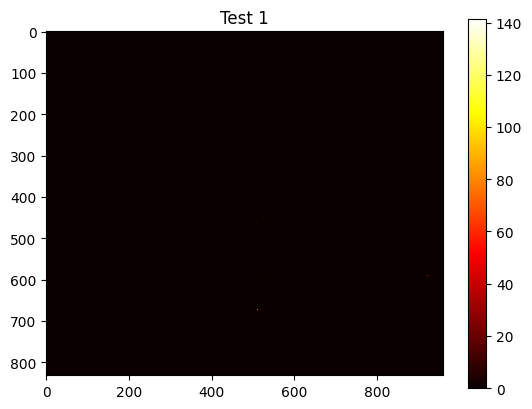

Test 2: Did not reach the goal.
Test 2, tics: 2110, success: False
Path: [(882, 763), (882, 763), (882, 763), (852, 711), (831, 687), (889, 702), (935, 713), (942, 689), (942, 687), (942, 687), (887, 711), (845, 729), (892, 754), (942, 787), (942, 800), (942, 803), (921, 814), (905, 814), (884, 757), (869, 713), (866, 703), (866, 700), (893, 646), (870, 682), (849, 719), (902, 709), (942, 688), (887, 702), (845, 716), (835, 719), (886, 692), (920, 687), (910, 747), (898, 793), (865, 751), (815, 687), (815, 687), (815, 687), (852, 734), (918, 814), (895, 767), (870, 731), (864, 723), (863, 721), (863, 721), (863, 721), (863, 721), (863, 721), (863, 721), (863, 721), (863, 721), (863, 721), (923, 729), (942, 735), (942, 736), (942, 736), (942, 736), (941, 796), (942, 815), (942, 815), (942, 815), (942, 815), (942, 815), (934, 755), (936, 769), (941, 804), (942, 812), (942, 814), (925, 814), (911, 814), (908, 814), (907, 814), (907, 814), (907, 814), (907, 814), (907, 814), (907, 814), (9

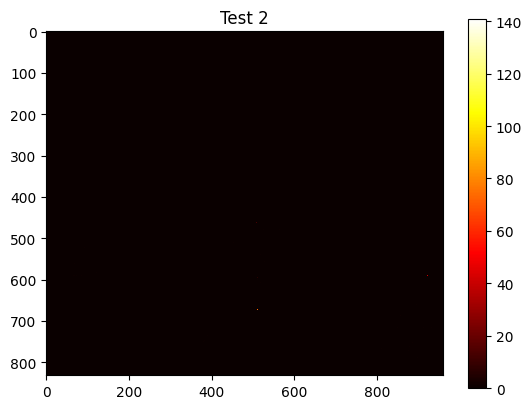

Test 3: Did not reach the goal.
Test 3, tics: 2110, success: False
Path: [(882, 763), (852, 711), (875, 683), (895, 659), (895, 617), (895, 594), (906, 533), (902, 546), (893, 580), (891, 588), (891, 589), (895, 627), (895, 658), (864, 719), (840, 762), (819, 712), (815, 689), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (815, 687), (862, 724), (942, 789), (914, 814), (894, 814), (889, 814), (847, 771), (815, 737), (809, 735), (808, 735), (808, 735), (808, 735), (808, 735), (808, 735), (808, 735), (808, 735), (808, 735), (808, 735), (808, 735), (808, 735), (808, 735), (808, 735), (808, 735), (8

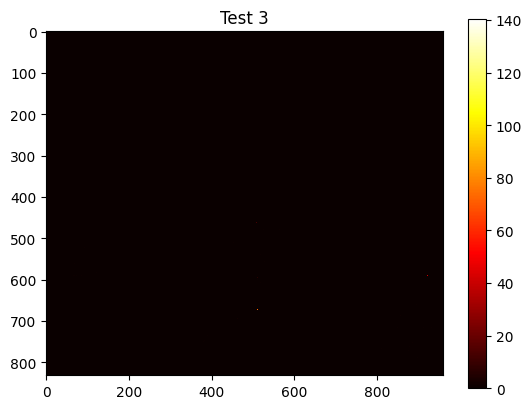

Test 4: Did not reach the goal.
Test 4, tics: 2110, success: False
Path: [(882, 763), (915, 814), (888, 761), (864, 721), (918, 724), (942, 735), (942, 742), (942, 743), (886, 722), (843, 706), (833, 702), (831, 701), (831, 701), (815, 693), (815, 687), (815, 687), (815, 687), (859, 727), (893, 758), (901, 765), (903, 767), (903, 767), (903, 767), (942, 794), (942, 809), (942, 813), (925, 814), (934, 756), (891, 690), (863, 664), (863, 658), (863, 657), (863, 657), (863, 657), (863, 657), (863, 657), (863, 657), (863, 657), (895, 623), (903, 574), (884, 496), (859, 453), (853, 443), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (852, 441), (8

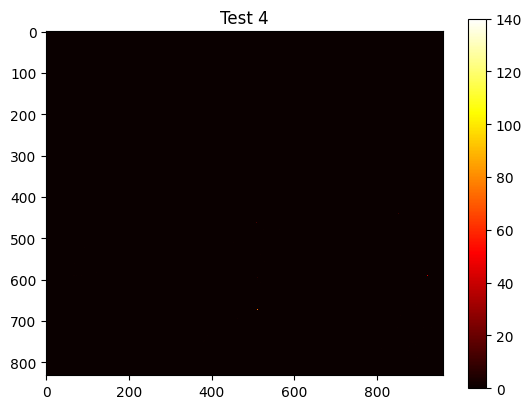

Test 5: Did not reach the goal.
Test 5, tics: 2110, success: False
Path: [(440, 511), (456, 511), (460, 511), (461, 511), (461, 511), (515, 537), (556, 557), (566, 561), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (568, 562), (5

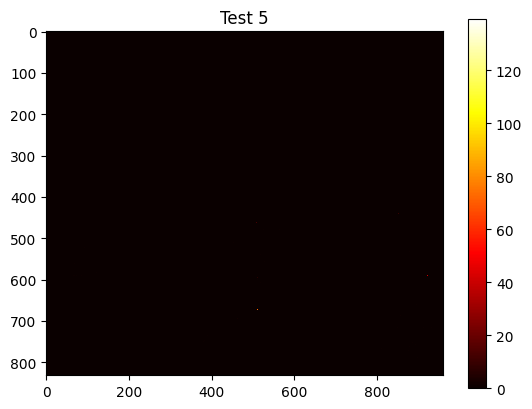

In [32]:
#Initialize the environment for testing
env = mywayhome_VZG(config_path=doomfinder("my_way_home.cfg"), pheromone_evaporation_rate=0.000025, render=True, frameskip=15) 

#Run the test function
test_saved_maps(env=env, num_tests=5, pheromone_grid=saved_pheromone_grid, alpha = 1, beta = 0.5) #Test the saved pheromone maps